In [ ]:
# Импорты библиотек
import pandas as pd
from random import choices
from numpy.random import poisson
from numpy import mean
import seaborn as sns
import matplotlib.pyplot as plt

## Bootstrap

Метод Bootstrap — это техника ресэмплинга, которая позволяет оценивать свойства статистик (например, среднего, медианы, дисперсии) путем многократного создания подвыборок из исходных данных с возвращением. В отличие от ЦПТ, Bootstrap не требует предположений о форме распределения данных.

**Ключевые моменты:**

* Bootstrap не требует знания истинного распределения данных.

* Он использует эмпирическое распределение исходных данных.

* Bootstrap может применяться для любых статистик, а не только для средних значений.


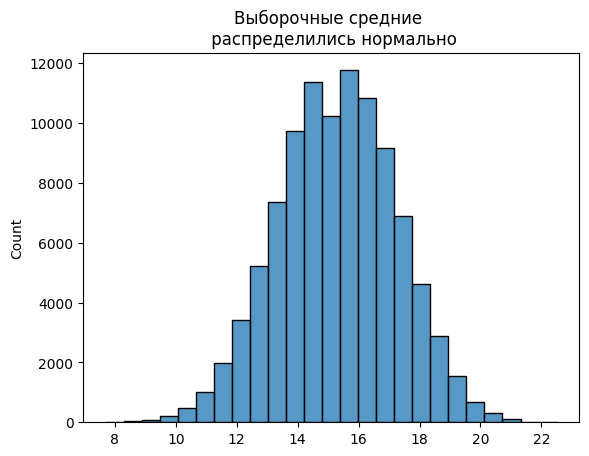

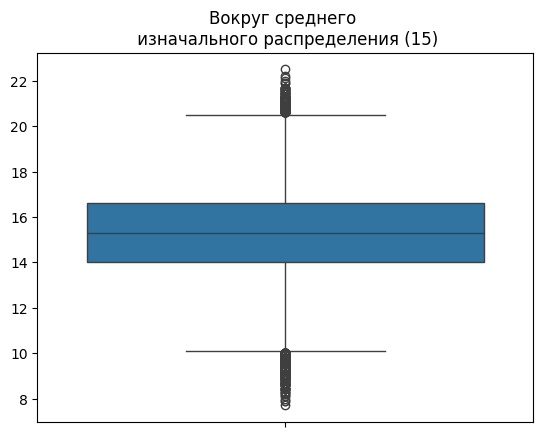

count    100000.000000
mean         15.293361
std           1.926858
min           7.700000
25%          14.000000
50%          15.300000
75%          16.600000
max          22.500000
dtype: float64


In [ ]:
# Распределение пуассона (не обязательно оно)
GP = poisson(lam=15, size=100)
x = choices(list(set(GP)), k=10)
# Bootstrap
data = []
for i in range(100_000):
    # Многократно выбираем выборочные средние (а можем и диспресию)
    y = choices(x, k=10)
    data.append(mean(y))

data = pd.Series(data)
sns.histplot(data, bins=25)
plt.title('Выборочные средние \n распределились нормально')
plt.show()
sns.boxplot(data)
plt.title('Вокруг среднего \n изначального распределения (15)')
plt.show()
print(data.describe())

## Jacknife

**Jackknife** — это метод ресэмплинга в статистике, который используется для оценки свойств статистических оценщиков (например, их смещения, дисперсии или стандартной ошибки).

Основная идея Jackknife заключается в последовательном исключении одного наблюдения из выборки, 
вычислении значения оценщика на оставшихся данных и использовании этих значений для анализа свойств оценщика. 

Это позволяет оценить, насколько чувствителен оценщик к отдельным наблюдениям, и скорректировать его значение для уменьшения смещения.

* Метод Jackknife помогает уменьшить смещение оценщика, особенно для небольших выборок.
* Этот метод особенно полезен, когда аналитическая форма смещения неизвестна или сложна для вычисления.

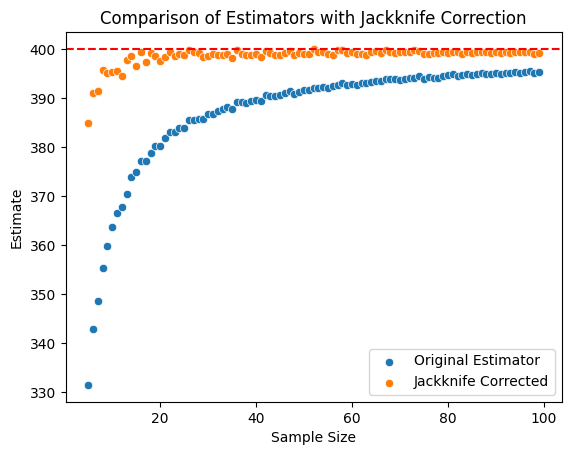

In [ ]:
# Определение оценщика: функция возвращает максимальное значение в выборке
def estimator(x):
    # Простой вариант, может рассчитыватьтся любой параметр
    return max(x)

# Функция для коррекции смещения методом Jackknife
def JN_bias_correction(x, estimator):
    n = len(x)  # Размер выборки
    theta_stars = []  # Список для хранения значений оценщика на подвыборках
    
    # Цикл для создания подвыборок методом Jackknife
    for elem in x:
        q = x.copy()  # Копируем исходную выборку
        q.remove(elem)  # Исключаем один элемент
        theta_stars.append(estimator(q))  # Вычисляем значение оценщика на подвыборке
    
    theta_hat = estimator(x)  # Значение оценщика на полной выборке
    theta_dot = mean(theta_stars)  # Среднее значение оценщика на всех подвыборках
    
    # Вычисление смещения (bias)
    bias_jack = (theta_dot - theta_hat) * (n - 1)
    
    # Коррекция оценки с учетом смещения
    theta_hat_jack = theta_hat - bias_jack
    
    return theta_hat_jack  # Возвращаем скорректированное значение

# Генерация данных для анализа
data = []
for k in range(5, 100):  # Размер выборки от 5 до 99
    for _ in range(1000):  # Повторяем эксперимент 1000 раз для каждого размера выборки
        x = choices([i for i in range(1, 400)], k=k)  # Создаем выборку из чисел от 1 до 399
        data.append((k, estimator(x), JN_bias_correction(x, estimator)))

# Преобразуем данные в DataFrame
df = pd.DataFrame(data, columns=["Sample Size", "Estimator", "Jackknife Corrected"])

# Группируем данные по размеру выборки и вычисляем средние значения
df = df.groupby("Sample Size").agg(['mean'])

# Визуализация результатов
sns.scatterplot(data=df["Estimator"]['mean'], label="Original Estimator")  # Исходный оценщик
sns.scatterplot(data=df["Jackknife Corrected"]['mean'], label="Jackknife Corrected")  # Скорректированный оценщик
plt.axhline(400, color='red', linestyle='--', label="True Maximum")  # Истинное максимальное значение
plt.xlabel("Sample Size")
plt.ylabel("Estimate")
plt.title("Comparison of Estimators with Jackknife Correction")
plt.show()